##### Copyright 2020 The TensorFlow Authors.

## Setup

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf


NUM_CLASSES = 3 #Bump/Road
IMG_SIZE =112 #SqueezeNet 90x90
SHOULD_TEST = False

EPOCHS = 40
BATCH_SIZE = 64

In [103]:
# import pandas
# import shutil 
# import os
# dataset_dir="D:\\GP\\New version\\NEWEST_DATASET_BUMPS\\001\\"
# csv_name="images.csv"
# csv_file = pandas.read_csv(dataset_dir+csv_name) # you can implement options as you want here)
# sorted_csv = csv_file.sort_values(by=['id'])
# class_names = list(sorted_csv['id'].unique())
# print(class_names)

# if not os.path.exists(dataset_dir+'001') or not os.path.exists(dataset_dir+'003'):
#   os.makedirs(os.path.join(dataset_dir+'001'))
#   os.makedirs(os.path.join(dataset_dir+'003'))
#   print("created")

# data_locs=["D:/GP/New version/PotHole/001/roads/","D:/GP/New version/PotHole/001/bumps/"]
# for i in class_names:
#   if i != 2:
#     temp='00'+str(i)          
#     for c in list(sorted_csv[sorted_csv['id']== i]['filename']):    # c  ->  individual image 
#     # Creating path to the image
#       get_image = os.path.join(dataset_dir,c)
#       # print(get_image)
#     # get_image to that path
#       if os.path.exists(dataset_dir+temp):
#           # move the image to this path
#           print(get_image,"Loaded to",temp)
#           move_image = shutil.copy(get_image,dataset_dir+temp)


In [104]:
# import pandas
# import shutil 
# import os
# csv_file = pandas.read_csv("D:/GP/New version/MIIA PotHole/train_ids_labels.csv") # you can implement options as you want here)
# sorted_csv = csv_file.sort_values(by=['Label'])
# class_names = list(sorted_csv['Label'].unique())
# print(class_names)
# print()
# if not os.path.exists('D:/GP/New version/PotHole/001') or not os.path.exists('D:/GP/New version/PotHole/002'):
#   os.makedirs(os.path.join('D:/GP/New version/PotHole/001'))
#   os.makedirs(os.path.join('D:/GP/New version/PotHole/002'))
#   print("created")

# for i in class_names:
#   temp='00'+str(i+1)          
#   for c in list(sorted_csv[sorted_csv['Label']== i]['Image_ID']):    # c  ->  individual image 
#   # Creating path to the image
#     get_image = os.path.join('D:/GP/New version/MIIA PotHole/all_data/all_data/',c+'.JPG')
#     # print(get_image)
#   # get_image to that path
#     if os.path.exists('D:/GP/New version/PotHole/'+temp):
#         # move the image to this path
#         print(get_image,"Loaded to",temp)
#         move_image = shutil.copy(get_image,'D:/GP/New version/PotHole/'+temp)


In [105]:
# # print(sorted_csv)
# road_images_count=len(sorted_csv[sorted_csv['Label']== 0])
# pothole_images_count=len(sorted_csv[sorted_csv['Label']== 1])
# print("road_images_count: "+str(road_images_count),"\npothole_images_count: "+str(pothole_images_count))


In [2]:
device_name = tf.test.gpu_device_name()
if not device_name:
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Note: all images are licensed CC-BY, creators are listed in the LICENSE.txt file.

In [107]:
import pathlib

data_dirs_string=['D:/GP/New version/NEWEST_DATASET_BUMPS','D:/GP/New version/train','D:/GP/New version/PotHole']
data_dirs=[]
for i in data_dirs_string:
  data_dirs.append(pathlib.Path(i))

# data_dir = 'D:/GP/New version/NEWEST_DATASET_BUMPS'
# data_dir = pathlib.Path(data_dir)

# data_dir2 = 'D:/GP/New version/train'
# data_dir2 = pathlib.Path(data_dir2)

# # data_dir3 = 'D:/GP/New version/train'
# # data_dir3 = pathlib.Path(data_dir2)

# data_dir3 = 'D:/GP/New version/PotHole'
# data_dir3 = pathlib.Path(data_dir3)
# image_count_train = len(list(data_dirs[0].glob('*/*.*')))+len(list(data_dirs[1].glob('*/*.*')))+len(list(data_dirs[2].glob('*/*.*'))) 
# print(image_count_train)


In [108]:
class_names=[]
for i in range(NUM_CLASSES):
  Class = np.array(sorted([item.name for item in data_dirs[i].glob('*') if item.name != "LICENSE.txt"]))
  for i in Class:
    if i not in class_names:
      class_names.append(i)
print(class_names)
# class_names = np.array(sorted([item.name for item in data_dir2.glob('*') if item.name != "LICENSE.txt"]))
# print(class_names)
# class_names = np.array(sorted([item.name for item in data_dir3.glob('*') if item.name != "LICENSE.txt"]))
# print(class_names)

['001', '002', '003']


In [112]:

dataSets=[tf.data.Dataset for x in range(NUM_CLASSES)]
dir=[]
image_count_train=np.zeros(NUM_CLASSES)

for j in range(NUM_CLASSES):
  for i in range(NUM_CLASSES):
  # if not os.path.exists(str(data_dirs[i]/+class_names[j]+'/*')): 
    temp=str(class_names[j]+'/*')
    dir.append(str(data_dirs[i]/temp))
  # print(dir)  
  dataSets[j]=(tf.data.Dataset.list_files(dir, shuffle=False))
  dir=[]
  image_count_train[j]=int(len(dataSets[j]))
  dataSets[j] = dataSets[j].shuffle(image_count_train[j], reshuffle_each_iteration=False)
  
print("Length of each dataset: ",image_count_train)

minIndex=np.argmin(image_count_train)
# print("Min. Length is: ",minLen)    

list_ds_train=dataSets[minIndex]
for i in range(NUM_CLASSES):
  if i != minIndex:
    # print("hi")
    list_ds_train = list_ds_train.concatenate(dataSets[i]) #.take(minLen))
minLen= len(list(list_ds_train.as_numpy_iterator()))
list_ds_train = list_ds_train.shuffle(NUM_CLASSES*minLen, reshuffle_each_iteration=False)

print('train size:' , len(list(list_ds_train.as_numpy_iterator())))
# list_ds_train = list_ds_train.batch(BATCH_SIZE).prefetch(2)

# list_ds_test = tf.data.Dataset.list_files([str(data_dir2/'*/*')], shuffle=False)
# list_ds_test = list_ds_test.shuffle(image_count_test, reshuffle_each_iteration=False)

Length of each dataset:  [6893. 4279. 2865.]
train size: 14037


In [113]:
for f in list_ds_train.take(5):
  print(f.numpy())

# for f in list_ds_test.take(5):
#   print(f.numpy())  

b'D:\\GP\\New version\\NEWEST_DATASET_BUMPS\\002\\20191011_070047 352.jpg'
b'D:\\GP\\New version\\train\\002\\bump (532).jpg'
b'D:\\GP\\New version\\train\\002\\bump (812).jpg'
b'D:\\GP\\New version\\NEWEST_DATASET_BUMPS\\001\\VIDEO0022 077.jpg'
b'D:\\GP\\New version\\train\\001\\unbump (207).jpg'


The tree structure of the files can be used to compile a `class_names` list.

Split the dataset into training and validation sets:

In [116]:
# image_count=sum(image_count_train)
# print(image_count*0.2)
test_size = int(minLen *0.2)
val_size = int(minLen * 0.2)
test_ds = list_ds_train.take(test_size)
val_ds = list_ds_train.skip(test_size).take(val_size)
train_ds = list_ds_train.skip(val_size+test_size)


You can print the length of each dataset as follows:

In [117]:
print('test size:' , len(list(test_ds.as_numpy_iterator())))
print('train size:' , len(list(train_ds.as_numpy_iterator())))
print('dev size:' , len(list(val_ds.as_numpy_iterator())))

test size: 2807
train size: 8423
dev size: 2807


Write a short function that converts a file path to an `(img, label)` pair:

In [118]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [119]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [IMG_SIZE, IMG_SIZE])

In [120]:
def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

Use `Dataset.map` to create a dataset of `image, label` pairs:

In [121]:
AUTOTUNE = tf.data.AUTOTUNE

In [122]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)


In [123]:
c=0
c1=0
c2=0
for image, label in train_ds:
  # print("Image shape: ", image.numpy().shape)
  # print("Label: ", label.numpy())
  if(label.numpy()==0):
    c=c+1
  elif (label.numpy()==1):
    c1=c1+1
  elif(label.numpy()==2):
    c2=c2+1
  # print(label.numpy())
print(c,c1,c2)
c=c1=c2=0
for image, label in test_ds:
  # print("Image shape: ", image.numpy().shape)
  # print("Label: ", label.numpy())

  if(label.numpy()==0):
    c=c+1
  elif (label.numpy()==1):
    c1=c1+1
  elif(label.numpy()==2):
    c2=c2+1
  # print(label.numpy())
print(c,c1,c2)
c=c1=c2=0
for image, label in val_ds:
  # print("Image shape: ", image.numpy().shape)
  # print("Label: ", label.numpy())

  if(label.numpy()==0):
    c=c+1
  elif (label.numpy()==1):
    c1=c1+1
  elif(label.numpy()==2):
    c2=c2+1
  # print(label.numpy())
print(c,c1,c2)


  # images.append(image)
  # labels.append(label.numpy())
  # 193 201 179

  # 178 218 177

4154 2556 1713
1374 865 568
1365 858 584


### Configure dataset for performance

To train a model with this dataset you will want the data:

* To be well shuffled.
* To be batched.
* Batches to be available as soon as possible.

These features can be added using the `tf.data` API. For more details, visit the [Input Pipeline Performance](../../guide/performance/datasets.ipynb) guide.

In [124]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

### Visualize the data

You can visualize this dataset similarly to the one you created previously:

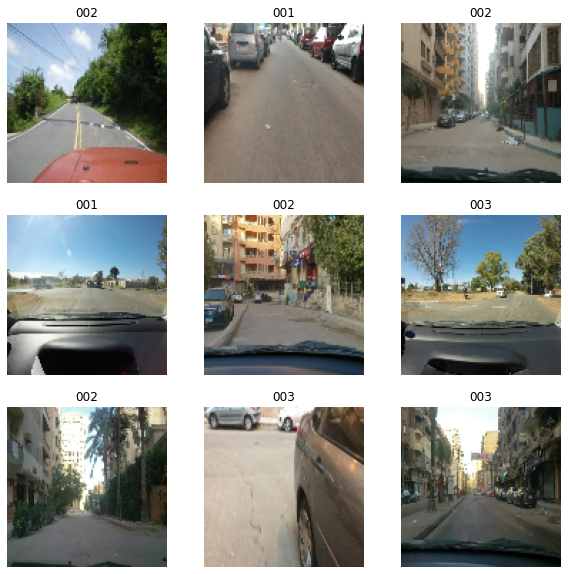

In [125]:
import matplotlib.pyplot as plt

image_batch, label_batch = next(iter(train_ds))
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

### Train a model

For completeness, you will show how to train a simple model using the datasets you have just prepared.

The [Sequential](https://www.tensorflow.org/guide/tf/sequential_model) model consists of three convolution blocks (`tf.tf.layers.Conv2D`) with a max pooling layer (`tf.tf.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.tf.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned in any way—the goal is to show you the mechanics using the datasets you just created. To learn more about image classification, visit the [Image classification](../images/classification.ipynb) tutorial.

In [126]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.layers import Dense, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, BatchNormalization, Concatenate, Dropout, Activation, Input, ZeroPadding2D, LayerNormalization
from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.metrics import Accuracy, Recall, Precision

def recall(y_true, y_pred):
    y_true = keras.backend.ones_like(y_true) 
    true_positives = keras.backend.sum(keras.backend.round(keras.backend.clip(y_true * y_pred, 0, 1)))
    all_positives = keras.backend.sum(keras.backend.round(keras.backend.clip(y_true, 0, 1)))
        
    recall = true_positives / (all_positives + keras.backend.epsilon())
    return recall

def precision(y_true, y_pred):
    y_true = keras.backend.ones_like(y_true) 
    true_positives = keras.backend.sum(keras.backend.round(keras.backend.clip(y_true * y_pred, 0, 1)))
    
    predicted_positives = keras.backend.sum(keras.backend.round(keras.backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + keras.backend.epsilon())
    return precision

def f1_score(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2*((prec*rec)/(prec+rec+keras.backend.epsilon()))


class FireModule(keras.layers.Layer):
    def __init__(self, s1x1, e1x1, e3x3):
        super(FireModule, self).__init__()
        self.s1x1 = Conv2D(s1x1, kernel_size=(1, 1), padding='same', kernel_initializer='glorot_normal', activation='relu')
        self.e1x1 = Conv2D(e1x1, kernel_size=(1, 1), padding='same', kernel_initializer='glorot_normal', activation='relu')
        self.e3x3 = Conv2D(e3x3, kernel_size=(3, 3), padding='same', kernel_initializer='glorot_normal', activation='relu')
        self.concat = Concatenate(axis=3)
    def get_config(self):
        base_config = super(FireModule, self).get_config()
        #base_config['output_dim'] = self.output_dim
        return base_config

    def call(self, inputs):
        s1x1 = self.s1x1(inputs)
        e1x1 = self.e1x1(s1x1)
        e3x3 = self.e3x3(s1x1)
        concat = self.concat([e1x1, e3x3])
        return concat

# def FireModule(s1, e1, e3, input):
#     squeeze = Conv2D(s1, kernel_size=(1, 1), padding='same', kernel_initializer='glorot_normal', activation='relu')(input)
#     expand1 = Conv2D(e1, kernel_size=(1, 1), padding='same', kernel_initializer='glorot_normal', activation='relu')(squeeze)
#     expand3 = Conv2D(e3, kernel_size=(3, 3), padding='same', kernel_initializer='glorot_normal', activation='relu')(squeeze)
#     concat = Concatenate(axis=1)([expand1, expand3])
#     return concat

def SqueezeNetV1_0(input_shape, nb_classes):
    
    
    input = Input(input_shape)
    padded = ZeroPadding2D((2, 2))(input)
    conv1 = Conv2D(96, kernel_size=(7, 7), strides=(2,2),padding='valid', kernel_initializer='glorot_normal', activation='relu')(padded)
    maxpool1 = MaxPooling2D(pool_size=(3, 3), strides=2)(conv1)
    fire2 = FireModule(16, 64, 64)(maxpool1)
    fire3 = FireModule(16, 64, 64)(fire2)
    fire4 = FireModule(32, 128, 128)(fire3)
    maxpool4 = MaxPooling2D(pool_size=(3, 3), strides=2)(fire4)
    fire5 = FireModule(32, 128, 128)(maxpool4)
    fire6 = FireModule(48, 192, 192)(fire5)
    fire7 = FireModule(48, 192, 192)(fire6)
    fire8 = FireModule(64, 256, 256)(fire7)
    maxpool8 = MaxPooling2D(pool_size=(3, 3), strides=2)(fire8)
    fire9 = FireModule(64, 256, 256)(maxpool8)
    conv10 = Conv2D(1000, kernel_size=(1, 1), strides=1, padding='same', kernel_initializer='glorot_normal', activation='relu')(fire9)
    avgpool10 = AveragePooling2D(conv10.get_shape()[1:3], strides=1)(conv10)
    #reshaped = tf.squeeze(avgpool10, [1, 2])
    flat = Flatten()(avgpool10)
    # output = Activation('softmax')(flat)
    output = Dense(nb_classes, activation='softmax', kernel_initializer='he_normal')(flat)


    model = Model(input, output, name='SqueezeNetV1_0x' + str(IMG_SIZE))
    model.compile(optimizer=Adam(learning_rate=0.001),
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
    return model

def SqueezeNetV1_1(input_shape, nb_classes):
    input = Input(input_shape)
    conv1 = Conv2D(64, kernel_size=(3, 3), strides=(2,2),padding='valid')(input)
    maxpool1 = MaxPooling2D(pool_size=(3, 3), strides=2)(conv1)
    fire2 = FireModule(16, 64, 64)(maxpool1)
    fire3 = FireModule(16, 64, 64)(fire2)
    maxpool3 = MaxPooling2D(pool_size=(3, 3), strides=2)(fire3)
    fire4 = FireModule(32, 128, 128)(maxpool3)
    fire5 = FireModule(32, 128, 128)(fire4)
    maxpool5 = MaxPooling2D(pool_size=(3, 3), strides=2)(fire5)
    fire6 = FireModule(48, 192, 192)(maxpool5)
    fire7 = FireModule(48, 192, 192)(fire6)
    fire8 = FireModule(64, 256, 256)(fire7)
    fire9 = FireModule(64, 256, 256)(fire8)
    dropout9 = Dropout(0.8)(fire9)
    conv10 = Conv2D(nb_classes, kernel_size=(1, 1), strides=1, padding='same', activation=None)(dropout9)
    avgpool10 = AveragePooling2D(conv10.get_shape()[1:3])(conv10)
    #reshaped10 = Flatten()(avgpool10)
    output = Flatten()(avgpool10)
    #output = Activation('softmax')(reshaped10)
    #output = Dense(nb_classes, activation='softmax', kernel_initializer='he_normal')(reshaped10)

    model = Model(input, output, name='SqueezeNetV1_1x' + str(IMG_SIZE))
    model.compile(optimizer='adam',
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy', precision, recall, f1_score])
    return model


def FLSCNN(input_shape, nb_classes):
    input = Input(input_shape)

    conv1 = Conv2D(8, kernel_size=(5, 5),activation='relu')(input)
    bn1 = LayerNormalization()(conv1)
    
    maxpool1 = MaxPooling2D(pool_size=(4, 4), strides=2, padding='same')(bn1)
    
    conv2 = Conv2D(16, kernel_size=(5, 5), activation='relu')(maxpool1)
    bn2 = LayerNormalization()(conv2)

    maxpool2 = MaxPooling2D(pool_size=(4, 4), strides=2, padding='same')(bn2)
    
    conv3 = Conv2D(16, kernel_size=(5, 5), activation='relu')(maxpool2)
    bn3 = LayerNormalization()(conv3)

    maxpool3 = MaxPooling2D(pool_size=(3, 3), strides=2)(bn3)

    conv4 = Conv2D(32, kernel_size=(5, 5), activation='relu')(maxpool3)
    bn4 = LayerNormalization()(conv4)

    maxpool4 = MaxPooling2D(pool_size=(5, 5), strides=2, padding='same')(bn4)

    conv5 = Conv2D(32, kernel_size=(1, 1), activation='relu', padding='same')(maxpool4)
    bn5 = LayerNormalization()(conv5)

    maxpool5 = MaxPooling2D(pool_size=(3, 3), strides=2, padding='valid')(bn5)

    #maxpool6 = MaxPooling2D(pool_size=(3, 3), strides=1, padding='valid')(maxpool5)

    fc1 = Dense(32, activation='tanh',)(maxpool5)
    fc2 = Dense(4, activation='tanh',)(fc1)
    fc3 = Dense(nb_classes, activation='softmax',)(fc2)

    output = Flatten()(fc3)

    model = Model(input, output, name='FLSCNNx' + str(IMG_SIZE))
    model.compile(optimizer=Adam(learning_rate=0.09),
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
    return model

Choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [127]:
for images, labels in train_ds.take(1):
    pass


In [128]:
model = SqueezeNetV1_1(images[0].numpy().shape, NUM_CLASSES)
model.summary()

Model: "SqueezeNetV1_1x112"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 112, 112, 3)]     0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 55, 55, 64)        1792      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 27, 27, 64)        0         
_________________________________________________________________
fire_module_8 (FireModule)   (None, 27, 27, 128)       11408     
_________________________________________________________________
fire_module_9 (FireModule)   (None, 27, 27, 128)       12432     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 128)       0         
_________________________________________________________________
fire_module_10 (FireModule)  (None, 13, 13, 256)

Note: You will only train for a few epochs so this tutorial runs quickly. 

In [129]:
import datetime
# Place the logs in a timestamped subdirectory
# This allows to easy select different training runs
# In order not to overwrite some data, it is useful to have a name with a timestamp
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# Specify the callback object
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch = (50,80))

# tf.keras.callback.TensorBoard ensures that logs are created and stored
# We need to pass callback object to the fit method
# The way to do this is by passing the list of callback objects, which is in our case just one

In [130]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


In [132]:
from shutil import rmtree

rmtree('./logs')
model.fit(
  train_ds,
  epochs=EPOCHS,
  validation_data=val_ds,
  callbacks=[tensorboard_callback, cp_callback]
)
model.save('models/'+model.name)


Epoch 1/40
132/132 [==============================] - 9s 66ms/step - loss: 0.1451 - accuracy: 0.9447 - precision: 1.0000 - recall: 1.1229 - f1_score: 1.0573 - val_loss: 0.4297 - val_accuracy: 0.8764 - val_precision: 1.0000 - val_recall: 1.1257 - val_f1_score: 1.0586

Epoch 00001: saving model to training_1\cp.ckpt
Epoch 2/40
132/132 [==============================] - 7s 54ms/step - loss: 0.1568 - accuracy: 0.9428 - precision: 1.0000 - recall: 1.1028 - f1_score: 1.0484 - val_loss: 0.4443 - val_accuracy: 0.8739 - val_precision: 1.0000 - val_recall: 1.1104 - val_f1_score: 1.0517

Epoch 00002: saving model to training_1\cp.ckpt
Epoch 3/40
132/132 [==============================] - 7s 54ms/step - loss: 0.1332 - accuracy: 0.9545 - precision: 1.0000 - recall: 1.1067 - f1_score: 1.0502 - val_loss: 0.4457 - val_accuracy: 0.8856 - val_precision: 1.0000 - val_recall: 1.1135 - val_f1_score: 1.0534

Epoch 00003: saving model to training_1\cp.ckpt
Epoch 4/40
132/132 [==============================] 

INFO:tensorflow:Assets written to: models/SqueezeNetV1_1x112\assets


INFO:tensorflow:Assets written to: models/SqueezeNetV1_1x112\assets


In [133]:
from tensorflow.keras.models import load_model

model = load_model('models/'+model.name, custom_objects={'recall': recall, 'precision': precision,'f1_score':f1_score})


In [134]:
test_accuracy = tf.keras.metrics.Accuracy()
#ds_test_batch = test_ds.batch(10)

loss, accuracy, prec, rec, f1 = model.evaluate(test_ds)
print("Loss :", loss)
print("Accuracy :", accuracy)
print("Precision :", prec)
print("Recall :", rec)
print("F1-Score :", f1)

#print("Test set accuracy: {:.3%}".format(test_accuracy.result()))


44/44 [==============================] - 49s 707ms/step - loss: 0.6053 - accuracy: 0.8874 - precision: 1.0000 - recall: 1.0913 - f1_score: 1.0433
Loss : 0.605276882648468
Accuracy : 0.8874242901802063
Precision : 1.0
Recall : 1.0912578105926514
F1-Score : 1.0432777404785156


In [58]:
print(test_ds.take(1))

<TakeDataset shapes: ((None, 112, 112, 3), (None,)), types: (tf.float32, tf.int64)>


In [66]:
import cv2
from uuid import uuid4


In [139]:
cap = cv2.VideoCapture("C:\src\project.avi")
images = []

while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:
        # print(frame.shape)
        image = tf.image.resize(frame, [IMG_SIZE, IMG_SIZE])
        image=tf.convert_to_tensor(frame)
        image= tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
        image= tf.expand_dims(image,0)
        
        # print(image.shape)

        # =frame.resize(112,112)
        label = np.argmax(model.predict(image))
        cv2.imshow('Frame',frame)
        # Filename
        # unique_id = str(uuid4())
        # filename = "D:\\GP\\New version\\New folder\\saved"+unique_id+'.jpg'
        print(label)

        # Using cv2.imwrite() method
        # Saving the image
        
        # cv2.imwrite(filename, frame)

        if label == 1:
            frame = cv2.circle(frame, (60,20), radius=0, color=(0, 0, 255), thickness=10) #for bumb
        elif label == 2:
            frame = cv2.circle(frame, (80,60), radius=0, color=(255, 0, 0), thickness=10) #for pothole
        
        cv2.putText(img=frame, text='bump', org=(0, 30), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=0.5, color=(0, 0, 255),thickness=0) 
        cv2.putText(img=frame, text='pothole', org=(0, 60), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=0.5, color=(255, 0, 0),thickness=0)
        cv2.imshow('Frame',frame)
        # Press Q on keyboard to  exit

        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
    else:
        break
cap.release()
cv2.destroyAllWindows()

0
0
0
1
1
1
1
1
0
0
1
0
0
1
2
1
1
1
1
1
1
1
1
0
1
1
1
0
1
0
1
0
1
1
0
0
1
0
1
1
0
0
0
1
0
1
1
0
0
0
0
1
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
1
0
1
1
0
0
1
0
1
0
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
0
1
1
1
1
1
0
0
0
1
0
0
0
0
0
1
1
1
1
1


In [100]:
import cv2
import numpy as np
import glob

img_array = []
for filename in glob.glob('C:\\Users\\Fat7y\\OneDrive\\Desktop\\test\\*.jpg'):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)


out = cv2.VideoWriter('project.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

In [88]:
c=c1=c2=0

for i in test:
  # label =np.argmax(model.predict(i))
  # cv2.imshow('Frame',i)
  # plt.imshow(image_batch[i].numpy().astype("uint8"))
  # print('class name: '+ str())
  if(label==0):
    c=c+1
  elif (label==1):
    c1=c1+1
  elif(label==2):
    c2=c2+1
print(c,c1,c2)


TypeError: Only integers, slices (`:`), ellipsis (`...`), tf.newaxis (`None`) and scalar tf.int32/tf.int64 tensors are valid indices, got <tf.Tensor: shape=(64, 112, 112, 3), dtype=float32, numpy=
array([[[[143.       , 184.       , 212.       ],
         [145.64285  , 185.35715  , 214.       ],
         [141.       , 188.       , 214.       ],
         ...,
         [141.49956  , 103.173004 ,  74.31583  ],
         [101.898155 ,  61.510532 ,  43.153214 ],
         [ 86.43853  ,  74.938896 ,  63.449535 ]],

        [[144.93878  , 186.03061  , 214.       ],
         [146.64285  , 186.35715  , 215.       ],
         [142.       , 189.       , 215.       ],
         ...,
         [108.75531  ,  76.41852  ,  46.479652 ],
         [120.22616  ,  94.654724 ,  58.134254 ],
         [135.09349  , 128.99171  , 133.75737  ]],

        [[141.85715  , 187.       , 213.42857  ],
         [143.7143   , 187.57143  , 214.42857  ],
         [142.39796  , 188.42857  , 214.42857  ],
         ...,
         [118.58146  , 117.234436 , 122.693504 ],
         [ 86.255264 ,  58.2552   ,  15.050957 ],
         [ 65.87811  ,  52.64365  ,  51.031765 ]],

        ...,

        [[ 10.571472 ,  20.571472 ,  30.571472 ],
         [  9.       ,  21.       ,  33.       ],
         [  9.       ,  21.       ,  33.       ],
         ...,
         [ 23.95919  ,  22.816246 ,  25.387718 ],
         [ 24.571472 ,  23.428528 ,  26.       ],
         [ 25.571472 ,  23.571472 ,  26.571472 ]],

        [[ 10.142883 ,  20.142883 ,  30.142883 ],
         [  7.       ,  19.       ,  31.       ],
         [  7.       ,  19.       ,  31.       ],
         ...,
         [ 23.       ,  23.       ,  25.       ],
         [ 23.       ,  23.       ,  25.       ],
         [ 22.673494 ,  21.326506 ,  24.       ]],

        [[ 10.       ,  20.       ,  30.       ],
         [  8.       ,  20.       ,  32.       ],
         [  8.       ,  20.       ,  32.       ],
         ...,
         [ 21.714294 ,  21.714294 ,  23.714294 ],
         [ 22.       ,  22.       ,  24.       ],
         [ 22.       ,  22.       ,  24.       ]]],


       [[[139.       , 184.       , 207.       ],
         [140.       , 185.       , 208.       ],
         [140.       , 185.       , 208.       ],
         ...,
         [100.11218  ,  84.11218  ,  68.11218  ],
         [ 96.62245  ,  77.62245  ,  77.479385 ],
         [109.01027  ,  84.2245   ,  61.79604  ]],

        [[139.       , 184.       , 207.       ],
         [139.14285  , 184.14285  , 207.14285  ],
         [139.14285  , 184.14285  , 207.14285  ],
         ...,
         [ 87.02036  ,  70.02036  ,  54.020367 ],
         [129.33665  , 110.836624 , 105.47938  ],
         [105.326485 ,  80.51012  ,  58.142857 ]],

        [[141.57143  , 186.57143  , 209.57143  ],
         [143.87755  , 187.77551  , 210.       ],
         [145.04082  , 186.07143  , 211.14285  ],
         ...,
         [120.95912  , 105.67338  ,  96.203964 ],
         [ 84.612526 ,  64.54099  ,  50.69407  ],
         [100.21423  ,  74.30605  ,  58.173462 ]],

        ...,

        [[ 10.428528 ,  24.428528 ,  33.428528 ],
         [ 12.       ,  25.       ,  34.       ],
         [ 15.142944 ,  24.       ,  34.571472 ],
         ...,
         [ 19.       ,  22.       ,  27.       ],
         [ 20.       ,  23.       ,  28.       ],
         [ 19.       ,  23.142944 ,  27.571472 ]],

        [[  9.061235 ,  25.969381 ,  34.       ],
         [ 12.       ,  25.       ,  34.       ],
         [ 15.92857  ,  23.92857  ,  34.92857  ],
         ...,
         [ 18.       ,  21.       ,  26.       ],
         [ 18.       ,  21.       ,  26.       ],
         [ 19.       ,  22.       ,  27.       ]],

        [[ 10.571428 ,  25.214287 ,  34.       ],
         [  9.       ,  26.       ,  34.       ],
         [ 13.714294 ,  23.714294 ,  33.714294 ],
         ...,
         [ 18.       ,  21.       ,  26.       ],
         [ 18.357178 ,  21.357178 ,  26.357178 ],
         [ 18.       ,  21.       ,  26.       ]]],


       [[[148.71428  , 193.71428  , 216.71428  ],
         [147.       , 193.       , 219.       ],
         [147.       , 193.       , 219.       ],
         ...,
         [150.       , 195.       , 224.       ],
         [150.       , 195.       , 224.       ],
         [150.       , 195.       , 224.       ]],

        [[149.       , 194.       , 215.       ],
         [149.       , 194.       , 217.       ],
         [148.85715  , 193.85715  , 216.85715  ],
         ...,
         [150.       , 196.       , 222.       ],
         [150.       , 196.       , 222.       ],
         [150.       , 196.       , 222.       ]],

        [[148.42857  , 193.42857  , 213.28572  ],
         [149.14285  , 192.85715  , 213.14285  ],
         [150.7143   , 194.42857  , 217.       ],
         ...,
         [150.       , 197.14285  , 220.57143  ],
         [150.       , 197.14285  , 220.57143  ],
         [150.57143  , 196.57143  , 220.57143  ]],

        ...,

        [[  7.571472 ,  21.428528 ,  28.142944 ],
         [  7.571472 ,  20.571472 ,  29.571472 ],
         [  7.       ,  21.       ,  32.       ],
         ...,
         [ 20.857056 ,  22.571472 ,  32.       ],
         [ 19.632645 ,  22.632645 ,  29.632645 ],
         [ 19.857056 ,  25.571472 ,  35.142944 ]],

        [[  7.       ,  22.       ,  27.       ],
         [  8.       ,  21.       ,  30.       ],
         [  5.2041073,  19.204107 ,  30.204107 ],
         ...,
         [ 18.       ,  21.       ,  30.       ],
         [ 20.       ,  20.       ,  28.       ],
         [ 19.       ,  23.       ,  32.       ]],

        [[  7.       ,  22.       ,  27.       ],
         [  7.3571434,  20.357143 ,  29.357143 ],
         [  6.       ,  20.       ,  31.       ],
         ...,
         [ 18.       ,  22.       ,  31.       ],
         [ 20.285645 ,  21.357178 ,  31.       ],
         [ 17.285828 ,  21.928528 ,  30.714294 ]]],


       ...,


       [[[150.2347   , 187.87755  , 214.66327  ],
         [154.       , 194.       , 220.       ],
         [153.       , 193.       , 219.       ],
         ...,
         [ 69.10205  ,  45.10205  ,  35.10205  ],
         [ 95.85715  ,  67.85715  ,  55.857143 ],
         [ 83.       ,  55.       ,  43.       ]],

        [[146.2857   , 183.92856  , 210.7143   ],
         [153.05103  , 193.05103  , 219.05103  ],
         [153.       , 193.       , 219.       ],
         ...,
         [ 71.55099  ,  47.550987 ,  37.265274 ],
         [ 76.34703  ,  48.34703  ,  37.34703  ],
         [ 77.060684 ,  50.7342   ,  38.387173 ]],

        [[134.62245  , 168.4796   , 198.86736  ],
         [151.22449  , 191.22449  , 217.22449  ],
         [153.       , 194.14285  , 219.57143  ],
         ...,
         [ 82.30615  ,  58.306152 ,  47.44901  ],
         [ 62.80605  ,  35.867363 ,  26.938757 ],
         [ 74.50005  ,  50.500053 ,  38.74489  ]],

        ...,

        [[  8.428528 ,  21.571472 ,  31.857056 ],
         [ 11.734749 ,  22.632626 ,  39.       ],
         [ 12.142944 ,  22.428528 ,  39.       ],
         ...,
         [ 12.571472 ,  18.571472 ,  30.571472 ],
         [ 13.204117 ,  19.204117 ,  31.204117 ],
         [ 12.234749 ,  21.908195 ,  29.898026 ]],

        [[  9.       ,  21.       ,  33.       ],
         [ 10.       ,  23.       ,  39.       ],
         [ 10.142883 ,  23.       ,  39.       ],
         ...,
         [ 11.       ,  17.       ,  29.       ],
         [ 12.       ,  18.       ,  30.       ],
         [ 12.857117 ,  21.857117 ,  30.857117 ]],

        [[  9.       ,  21.       ,  33.       ],
         [  7.       ,  20.       ,  36.       ],
         [  7.       ,  20.       ,  36.       ],
         ...,
         [ 12.       ,  18.       ,  30.       ],
         [ 10.642822 ,  17.357178 ,  29.       ],
         [ 10.285706 ,  18.285706 ,  29.285706 ]]],


       [[[145.       , 191.       , 215.       ],
         [146.       , 185.       , 214.       ],
         [145.       , 184.       , 213.       ],
         ...,
         [132.71436  , 160.71436  , 184.71436  ],
         [129.14299  , 154.42863  , 179.78581  ],
         [ 92.67404  , 124.67404  , 147.67404  ]],

        [[145.21428  , 190.81633  , 214.85715  ],
         [147.       , 192.       , 215.       ],
         [145.       , 190.       , 213.       ],
         ...,
         [100.245026 , 115.102165 , 143.81645  ],
         [135.17337  , 150.13257  , 178.79584  ],
         [142.53065  , 177.53065  , 199.24495  ]],

        [[144.85715  , 192.33673  , 213.87755  ],
         [145.85715  , 193.27551  , 215.08163  ],
         [146.       , 191.85715  , 212.42857  ],
         ...,
         [134.74504  , 154.17361  , 178.45932  ],
         [113.081764 , 129.1022   , 151.52055  ],
         [158.0718   , 186.38821  , 204.76575  ]],

        ...,

        [[ 10.       ,  20.       ,  30.       ],
         [  7.724518 ,  19.724518 ,  31.724518 ],
         [  7.1735544,  19.173553 ,  31.173553 ],
         ...,
         [ 22.826454 ,  22.826454 ,  24.826454 ],
         [ 22.857056 ,  22.857056 ,  24.857056 ],
         [ 22.857056 ,  22.857056 ,  24.857056 ]],

        [[ 10.142883 ,  20.142883 ,  30.142883 ],
         [  7.       ,  19.       ,  31.       ],
         [  6.       ,  18.       ,  30.       ],
         ...,
         [ 23.132679 ,  23.132679 ,  25.132679 ],
         [ 23.       ,  23.       ,  25.       ],
         [ 22.       ,  22.       ,  24.       ]],

        [[ 10.       ,  20.       ,  30.       ],
         [  7.       ,  19.       ,  31.       ],
         [  7.       ,  19.       ,  31.       ],
         ...,
         [ 21.714294 ,  21.714294 ,  23.714294 ],
         [ 22.       ,  22.       ,  24.       ],
         [ 21.785767 ,  22.       ,  24.       ]]],


       [[[149.28572  , 191.28572  , 216.28572  ],
         [146.28572  , 190.28572  , 217.28572  ],
         [146.28572  , 190.28572  , 215.28572  ],
         ...,
         [156.       , 195.       , 224.       ],
         [155.74487  , 195.25513  , 224.       ],
         [153.       , 197.       , 224.       ]],

        [[148.       , 193.       , 216.       ],
         [148.5      , 193.5      , 214.5      ],
         [147.85715  , 191.85715  , 218.57143  ],
         ...,
         [155.13266  , 197.13266  , 222.13266  ],
         [155.64282  , 195.35718  , 224.       ],
         [153.       , 197.       , 224.       ]],

        [[153.14285  , 196.42857  , 220.       ],
         [151.57143  , 194.85715  , 218.42857  ],
         [152.14285  , 195.42857  , 219.       ],
         ...,
         [154.11226  , 197.25511  , 221.93875  ],
         [155.2755   , 196.29593  , 222.85715  ],
         [154.69395  , 195.6428   , 222.28572  ]],

        ...,

        [[  7.       ,  22.       ,  27.       ],
         [  8.       ,  20.       ,  32.       ],
         [  8.       ,  20.       ,  32.       ],
         ...,
         [ 20.428528 ,  23.969398 ,  34.244957 ],
         [ 20.       ,  24.       ,  35.367355 ],
         [ 18.663277 ,  27.05114  ,  37.       ]],

        [[  7.       ,  22.       ,  27.       ],
         [  7.0510297,  19.05103  ,  31.05103  ],
         [  7.       ,  19.       ,  31.       ],
         ...,
         [ 20.       ,  24.       ,  33.       ],
         [ 21.       ,  24.       ,  33.       ],
         [ 17.       ,  23.326506 ,  34.673492 ]],

        [[  7.       ,  22.       ,  27.       ],
         [  6.7142944,  18.714294 ,  30.714294 ],
         [  7.       ,  19.       ,  31.       ],
         ...,
         [ 18.       ,  25.       ,  33.       ],
         [ 20.       ,  23.       ,  32.       ],
         [ 18.       ,  22.       ,  33.       ]]]], dtype=float32)>

In [83]:
cv2.destroyAllWindows()
model.layers[3].get_weights()

[array([[[[-0.2394451 ,  0.1377888 , -0.3887985 , ...,  0.10166059,
           -0.4737047 , -0.2588726 ],
          [ 0.28315616, -0.04193174,  0.06288209, ...,  0.28426528,
            0.10275009, -0.09210429],
          [ 0.05206992,  0.1251021 ,  0.07923146, ...,  0.2340574 ,
            0.54219544,  0.30070463],
          ...,
          [ 0.1512756 , -0.1751632 ,  0.19786114, ...,  0.06137332,
           -0.02336802, -0.08782809],
          [ 0.22484575, -0.11333247,  0.05239358, ...,  0.12902804,
            0.18767723, -0.01336721],
          [ 0.06669755,  0.18645968,  0.06389662, ..., -0.43401945,
            0.18028288,  0.30644137]]]], dtype=float32),
 array([ 0.22187784,  0.2680093 ,  0.06385788, -0.03874194,  0.07261151,
        -0.29130974,  0.009453  , -0.0914929 ,  0.27232462, -0.15219124,
        -0.2580048 ,  0.01548327, -0.05868456,  0.06773803,  0.4653401 ,
         0.01055273], dtype=float32),
 array([[[[ 0.10621721,  0.02602685, -0.31422323, ..., -0.11411405,
     

In [ ]:
weights = model.layers[1].get_weights()

In [ ]:
weights.shape

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
weights[:,:,2,60]

array([[ 0.00660257,  0.05393029,  0.07871939],
       [-0.02834111,  0.02452181, -0.05535853],
       [-0.11845279, -0.07768951, -0.08921076]], dtype=float32)